In [1]:
%env THEANO_FLAGS='device=cuda', 'floatX=float32', 'gpuarray.preallocate=0.2'

env: THEANO_FLAGS='device=cuda', 'floatX=float32', 'gpuarray.preallocate=0.2'


In [2]:
from psgd.sampling import SimpleSampler
from psgd.grouping import greedy_pairing_labels, greedy_pairing

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from craynn.utils import mnist

from tqdm import tqdm_notebook

Using cuDNN version 7005 on context None
Preallocating 1622/8110 Mb (0.200000) on cuda
Mapped name None to device cuda: GeForce GTX 1080 (0000:01:00.0)


## Data

In [4]:
X_train_original, _, X_test_original, _ = mnist(cast='float32')

In [5]:
X_train_original /= 255.0
X_test_original /= 255.0

In [6]:
X_train_original += np.random.normal(0, 0.5, size=X_train_original.shape)
X_test_original += np.random.normal(0, 0.5, size=X_test_original.shape)

In [8]:
from skimage.transform import rotate

angle = np.random.uniform(0, 0.5, size=X_train_original.shape[0])

X_train_rot = np.array([
    rotate(X_train_original[i, 0], -angle[i], order=3, resize=False, preserve_range=True).reshape(1, 28, 28)
    for i in tqdm_notebook(range(X_train_original.shape[0]))
]).astype('float32')

X_train_original = np.array([
    rotate(X_train_rot[i, 0], angle[i], order=3, resize=False,  preserve_range=True).reshape(1, 28, 28)
    for i in tqdm_notebook(range(X_train_rot.shape[0]))
]).astype('float32')

angle = np.random.uniform(0, 0.5, size=X_test_original.shape[0])

X_test_rot = np.array([
    rotate(X_test_original[i, 0], -angle[i], order=3, resize=False,  preserve_range=True).reshape(1, 28, 28)
    for i in tqdm_notebook(range(X_test_original.shape[0]))
]).astype('float32')

X_test_original = np.array([
    rotate(X_test_rot[i, 0], angle[i], order=3, resize=False,  preserve_range=True).reshape(1, 28, 28)
    for i in tqdm_notebook(range(X_test_rot.shape[0]))
]).astype('float32')

HBox(children=(IntProgress(value=0, max=60000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=60000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

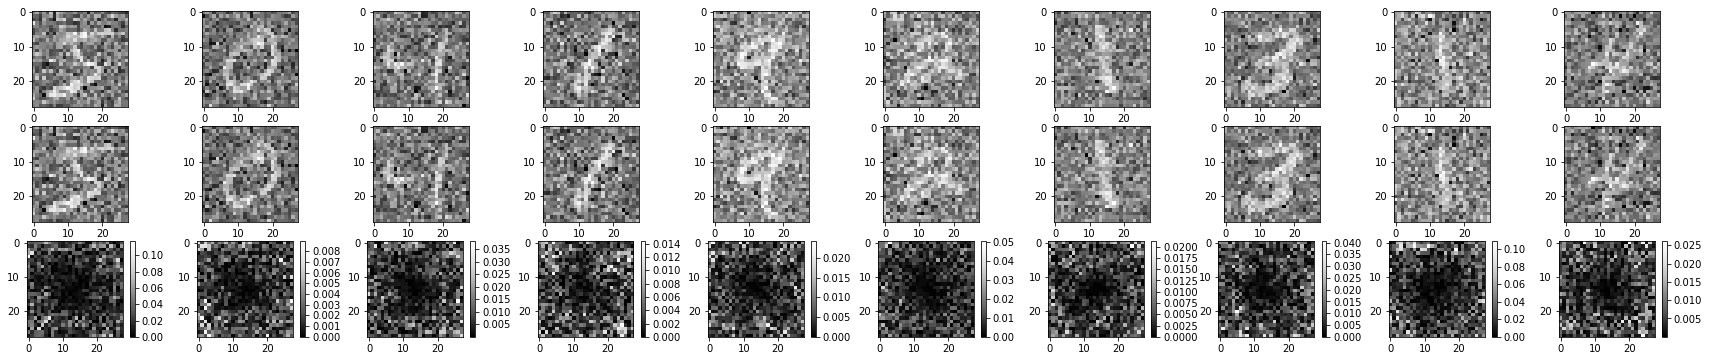

In [9]:
plt.subplots(nrows=3, ncols=10, figsize=(30, 6))

for j in range(10):
    plt.subplot(3, 10, j + 1)
    plt.imshow(X_train_original[j, 0], cmap=plt.cm.Greys_r)

    plt.subplot(3, 10, j + 10 + 1)
    plt.imshow(X_train_rot[j, 0], cmap=plt.cm.Greys_r)
    
    plt.subplot(3, 10, j + 20 + 1)
    plt.imshow(np.abs(X_train_original[j, 0] - X_train_rot[j, 0]), cmap=plt.cm.Greys_r)
    plt.colorbar()

In [10]:
X_train = np.vstack([X_train_original, X_train_rot])
y_train = np.hstack([
    np.ones(X_train_original.shape[0], dtype='float32'),
    np.zeros(X_train_rot.shape[0], dtype='float32')
])

In [11]:
indx = np.random.permutation(X_train.shape[0])
X_train = X_train[indx]
y_train = y_train[indx]

In [12]:
X_test = np.vstack([X_test_original, X_test_rot])
y_test = np.hstack([
    np.ones(X_test_original.shape[0], dtype='float32'),
    np.zeros(X_test_rot.shape[0], dtype='float32')
])

## Network

In [13]:
import theano
import theano.tensor as T

from craynn.utils import mnist

from craynn.layers import *
from craynn.networks import *
from craynn.subnetworks import *
from craynn.updates import *
from craynn.utils import lsum
from craynn.viz import SNNWatcher, draw_to_notebook

In [14]:
n = 8

nn = net((None, 1, 28, 28))(
    conv(n), conv(n), max_pool(),
    conv(int(1.5 * n)), conv(int(1.5 * n)), max_pool(),
    conv(2 * n), dense(1, f = lambda x: x),
    flatten(outdim=1)
)

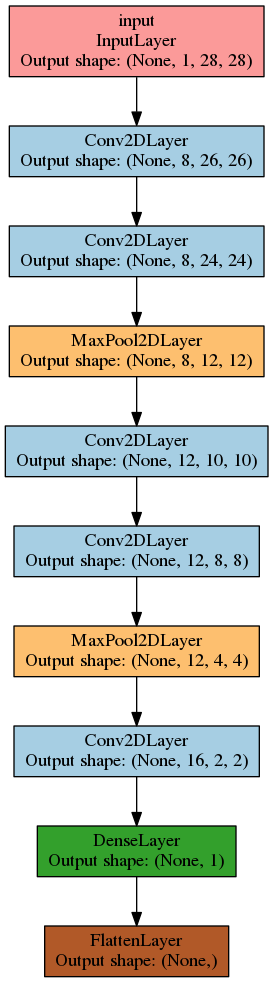

In [15]:
draw_to_notebook(nn)

In [16]:
print(nn.description())

Net
(None, 1, 28, 28) -> (None,)
total number of params: 4657
  output shape:(None, 1, 28, 28)
  number of params: 0.0
  output shape:(None, 8, 26, 26)
  number of params: 80
  output shape:(None, 8, 24, 24)
  number of params: 584
  output shape:(None, 8, 12, 12)
  number of params: 0.0
  output shape:(None, 12, 10, 10)
  number of params: 876
  output shape:(None, 12, 8, 8)
  number of params: 1308
  output shape:(None, 12, 4, 4)
  number of params: 0.0
  output shape:(None, 16, 2, 2)
  number of params: 1744
  output shape:(None, 1)
  number of params: 65
  output shape:(None,)
  number of params: 0.0


In [17]:
X = T.ftensor4()
y = T.fvector()

w = T.fvector()

In [18]:
f, = nn(X)

In [19]:
losses = y * T.nnet.softplus(-f) + (1 - y) * T.nnet.softplus(f)

loss = T.mean(w * losses)

In [20]:
grad = theano.grad(T.sum(losses), nn.params())

grad_norm = T.sqrt(
    lsum([ T.sum(g ** 2) for g in grad ])
)

In [21]:
get_grad_norm = theano.function([X, y], grad_norm)

In [22]:
learning_rate = T.fscalar()

upd, rst = resetable.adam(grad, nn.params(), learning_rate=learning_rate)

train = theano.function(
    [X, y, w, learning_rate],
    [loss, grad_norm],
    updates=upd, allow_input_downcast=True
)

reset = theano.function([], None, updates=rst)

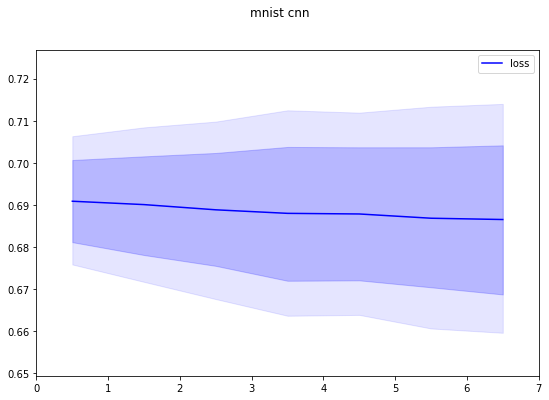

KeyboardInterrupt: 

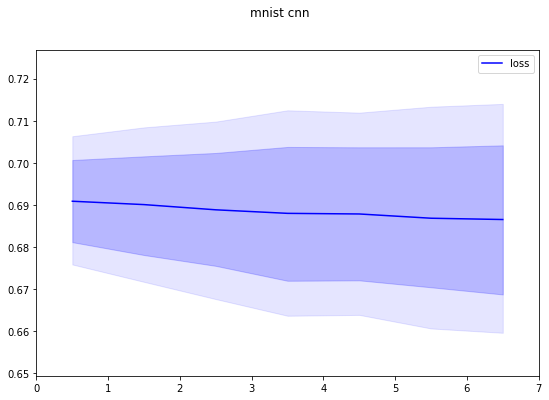

In [28]:
watcher = SNNWatcher(title='mnist cnn', mode='fill')

num_epoches = 32
num_batches = X_train.shape[0] // 32

losses = np.ndarray(shape=(num_epoches, num_batches), dtype='float32')
w = np.ones(shape=(X_train.shape[0], ), dtype='float32')

stream = streams.inf_random(X_train.shape[0], batch_size=32)

for i in range(num_epoches):
    for j in range(num_batches):
        indx = next(stream)
        losses[i, j], _ = train(X_train[indx], y_train[indx], w[indx], 1.0e-3)
    
    watcher.draw(losses[:(i + 1)])

In [29]:
predict = theano.function([X], T.nnet.sigmoid(f))

In [30]:
predict(X_train[:10]).shape

(10,)

In [31]:
np.sum([
    np.sum((predict(X_test[indx]) > 0.5) == y_test[indx])
    for indx in streams.seq(X_test.shape[0], batch_size=128)
]) / X_test.shape[0]

0.54065